In [1]:
# mount drive 
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# import os
# os.chdir('./drive/MyDrive/NLP/project')
# !ls

data  embeddings  turkish_main.ipynb  utilities


In [3]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np
import json
import os
from utilities.word_embeddings import WordEmbedding
from utilities.plots import *

### 1: Gender Bias in Word Embedding

### Data
January-December 2018 Commoncrawl
### Load data
Load the word embedding. The embedding maps each word into a 300-dimension vector. 

In [4]:
def load_professions():
    '''
       load data from profession.json 
    '''
    professions_file = os.path.join('./data', 'professions.json')
    with open(professions_file, 'r') as f:
        professions = json.load(f)
    # print('Loaded professions\n' +
    #       'Format:\n' +
    #       'word,\n' +
    #       'definitional female -1.0 -> definitional male 1.0\n' +
    #       'stereotypical female -1.0 -> stereotypical male 1.0')
    return professions

In [5]:
# load turkish Glove
E = WordEmbedding()
E.load_embeddings('./embeddings/turkish_vectors.txt')

# load professions
professions = load_professions()
profession_words = [p[0] for p in professions]

(253832, 300)


### 2: Define gender direction

We have used Woman - Man here to get the gender direction in the vector space.

In [6]:
v_gender = E.diff('kadını', 'adam')

### Corpus and vocab size is very large. Taking a subset of the vocab to calculate the score.

#### Generate analogies

In [7]:
a_gender = E.get_analogy_based_thresh(v_gender,max_words=30000)

Computing neighbors


In [8]:
she_occupation = ['homemaker', 'nurse', 'receptionist', 'librarian', 'socialite', 'hairdresser', 
'nanny', 'bookkeeper', 'stylist', 'housekeeper', 'designer', 'sewing']

# she_occupation_turkish = []

### Normal install of googletrans didn't work, had to install alpha version.
https://stackoverflow.com/questions/52455774/googletrans-stopped-working-with-error-nonetype-object-has-no-attribute-group

In [10]:
# !pip install googletrans==3.1.0a0

In [11]:
from googletrans import Translator
translator = Translator()

### Helper Function to translate words from source language to target language

In [12]:
def get_translation(src_list,src_lang, tgt_lang):
  return [item.text for item in translator.translate(src_list, src=src_lang, dest=tgt_lang)]

  # for item in src_list:
  #   target = translator.translate(item, src=src_lang, dest=tgt_lang).text
  #   target_list.append(target)
  # return target_list

In [13]:
she_occupation_turkish = get_translation(she_occupation, 'en', 'tr')

In [14]:
for en, tr in zip(she_occupation, she_occupation_turkish):
  print(en, '\t\t\t', tr)

homemaker 			 ev hanımı
nurse 			 hemşire
receptionist 			 resepsiyonist
librarian 			 kütüphaneci
socialite 			 sosyetik
hairdresser 			 kuaför
nanny 			 dadı
bookkeeper 			 muhasebeci
stylist 			 stilist
housekeeper 			 kahya
designer 			 tasarımcı
sewing 			 dikiş


In [15]:
E.word2index['kadını']

3310

In [17]:
counter = 1
for (a,b,c) in a_gender:
    a,b = get_translation([a,b], 'tr', 'en')
    # if a in she_occupation_turkish:
    print(a+"-"+b+"-"+str(c))
    counter += 1 
    if counter > 50:
      break

woman-man-1.0
woman's-your man-0.72630006
to the woman-to the man-0.62636423
with woman-with the man-0.5674051
is a woman-is the man-0.5071459
from woman-from the man-0.48661
women-people-0.4651298
women-peoples-0.45814937
Hatice-Ali-0.44985628
lady-handsome-0.4485165
fatma-Hasan-0.44597846
older sister-brother-0.43073273
woman-gentleman-0.43001527
eminem-Ahmet-0.4250175
my cinema-tolga-0.41986892
daughter-son--0.4099087
our women-our youth-0.40680158
auntie-uncle-0.40375972
women-youth-0.40034848
my daughter-my son-0.40021813
wife-his father-0.39926654
to women-to children-0.39407244
betül-Hakan-0.39406663
from women-from people-0.3895776
to the lady-gentleman-0.38849005
lady-gentleman-0.38553262
Lady-Mr-0.37853307
with women-with people-0.37557966
woman-youth-0.3752285
you are right-huh-0.37075862
dear-mate-0.3707531
my partner-my father-0.3687628
actress-player-0.36851406
tugba-serdar-0.36611634
my older sister-my brother-0.36140114
ayse-Mehmet-0.3581946
ladies-guys-0.3567136
Esra-m

### Translate English profession words to Turkish

In [18]:
profession_words_turkish = get_translation(profession_words, 'en', 'tr')

In [19]:
profession_words_turkish[:10]

['Muhasebeci',
 'tanıdık',
 'aktör',
 'aktris',
 'yardımcı profesör',
 'yönetici',
 'maceracı',
 'avukat',
 'yardımcı',
 'meclis üyesi']

### Get embeddings, Handle exception for those words which are not part of the corpus

In [20]:
def get_embed(word):
  try:
    return E.embeddings[E.word2index[word]]
  except KeyError:
    return -1


### Check the gender bias

In [21]:
# sp = sorted([(E.get_embedding(w).dot(v_gender), w) for w in profession_words_turkish])
sp = []
counter = 0 
for word in profession_words_turkish:
  sim = get_embed(word)
  if isinstance(sim, int):
    # print('word not found: ', word)
    counter +=1 
  else:
    sp.append((sim.dot(v_gender), word))


In [22]:
sp = sorted(sp)

In [23]:
she_words = get_translation([item[1] for item in sp[-20:]], 'tr', 'en')
he_words = get_translation([item[1] for item in sp[0:20]], 'tr', 'en')

In [24]:
she_words1 = []
for item1, item2 in zip(she_words, sp[-20:]):
  she_words1.append((item2[0], item1))

In [25]:
he_words1 = []
for item1, item2 in zip(he_words, sp[0:20]):
  he_words1.append((item2[0], item1))

### Gender Bias in Profession
* He professions are on the negative side of x-axis 
* She professions are on the positive side of x-axis

In [26]:
plot_words_extreme(he_words1, she_words1, 40, x_title='Word Extremes', y_title='Similarity', 
title='Gender Bias In Profession')

### Professions on Male side of the axis

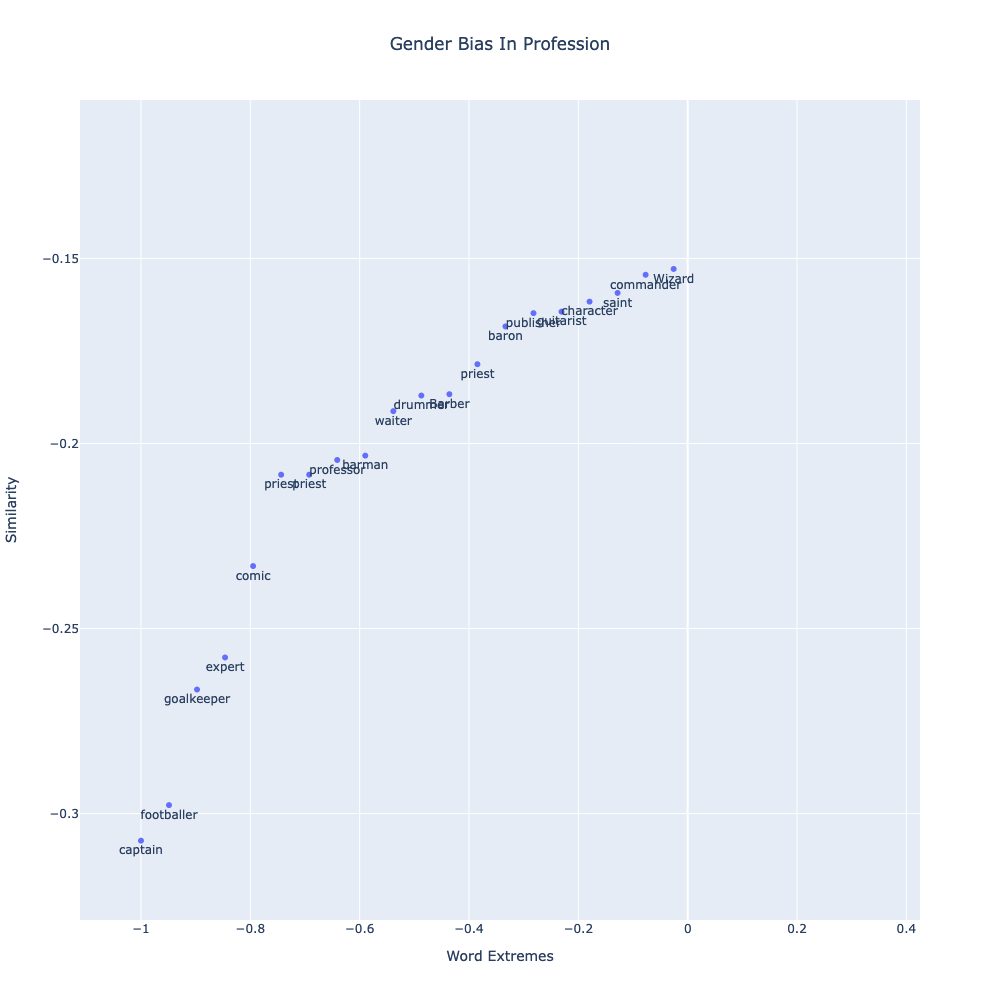

### Professions on Female side of the axis

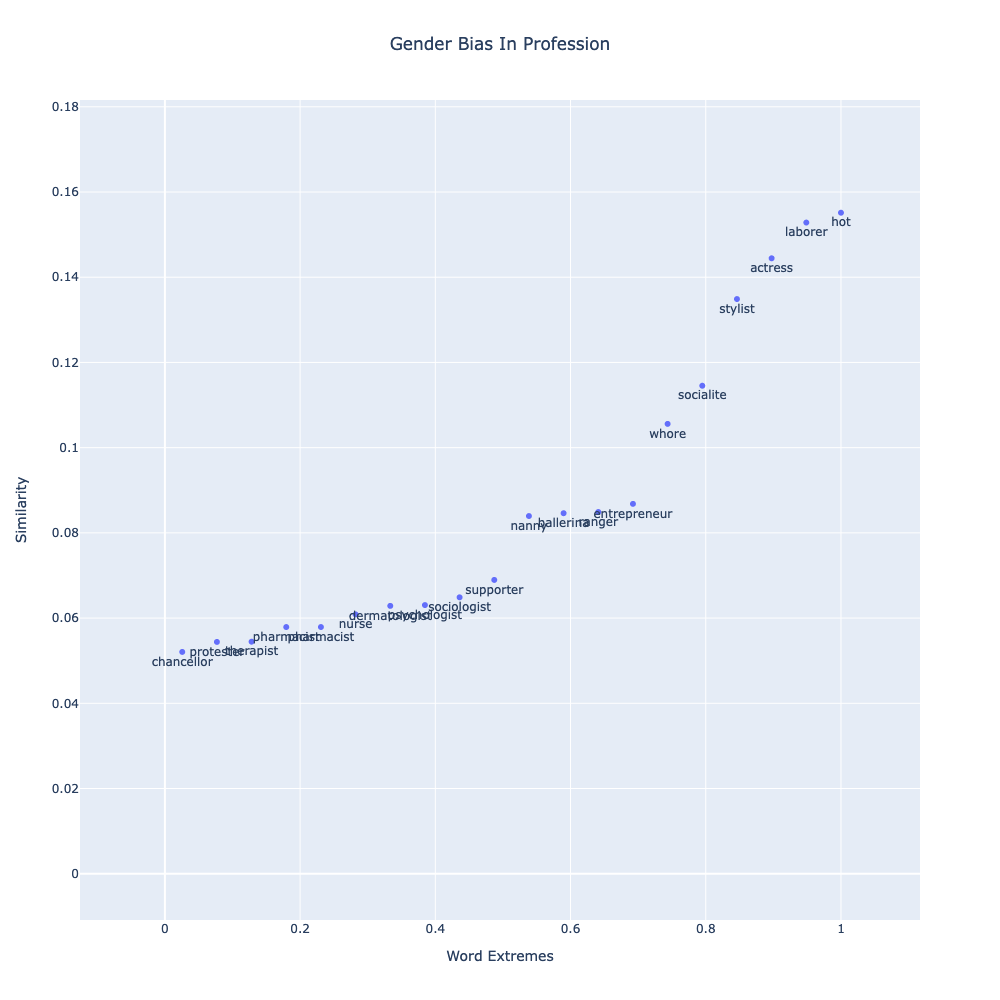